In [226]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('cleaned_and_wrangled.csv')

# Baselines


In [227]:
### My baselines:
df['Product'].value_counts(normalize=True)
### I want to predict what factors cause people to purchase accessories

Accessory    0.759163
Boat B       0.094369
Boat A       0.085662
Boat D       0.035529
Boat C       0.021064
Boat E       0.004213
Name: Product, dtype: float64

# Wrangling

In [228]:
### Dropping an unneccesary column
df = df.drop(columns=['Unnamed: 0'])

###Turn dates into datetime objects
print(type(df['Date'][0]))
#df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
##Checking to make sure it worked
print(type(df['Date'][0]))

print(df.shape)
df.head(5)

<class 'numpy.int64'>
<class 'numpy.int64'>
(7121, 9)


,Transaction ID,Date,Product,Source,Count of Sessions,Quantity,Product Revenue,Landing Page,Device Category
0,#11963,20191231,Accessory,knoji.com,5,1,$25.00,/cart,desktop
1,#11963,20191231,Boat A,knoji.com,5,1,"$1,599.00",/cart,desktop
2,#11960,20191230,Boat C,affirm.com,3,1,"$2,199.00",/checkout/thank_you,mobile
3,#11960,20191230,Accessory,affirm.com,3,1,$99.00,/checkout/thank_you,mobile
4,#11960,20191230,Accessory,affirm.com,3,1,$110.00,/checkout/thank_you,mobile


In [229]:
##Turn prices into numbers not strings
print(type(df['Product Revenue'][0]))
df['Product Revenue'] = df['Product Revenue'].str.replace(',','')
df['Product Revenue'] = df['Product Revenue'].str.strip('[\$,]')

df['Product Revenue'] = pd.to_numeric(df['Product Revenue'])
print(type(df['Product Revenue'][0]))

display(df.head(5))

### Now that I did all that, I realize that I probably will have to drop the Revenue column becuase it's a form of data leakage.

<class 'str'>
<class 'numpy.float64'>


,Transaction ID,Date,Product,Source,Count of Sessions,Quantity,Product Revenue,Landing Page,Device Category
0,#11963,20191231,Accessory,knoji.com,5,1,25.0,/cart,desktop
1,#11963,20191231,Boat A,knoji.com,5,1,1599.0,/cart,desktop
2,#11960,20191230,Boat C,affirm.com,3,1,2199.0,/checkout/thank_you,mobile
3,#11960,20191230,Accessory,affirm.com,3,1,99.0,/checkout/thank_you,mobile
4,#11960,20191230,Accessory,affirm.com,3,1,110.0,/checkout/thank_you,mobile


# Visualizations

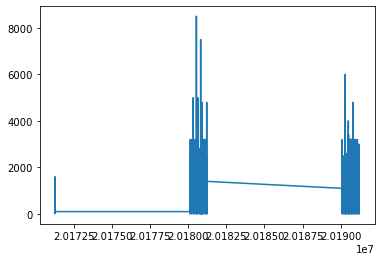

In [230]:
plt.plot(df['Date'], df['Product Revenue'])

### But at least it makes a nicer looking plot

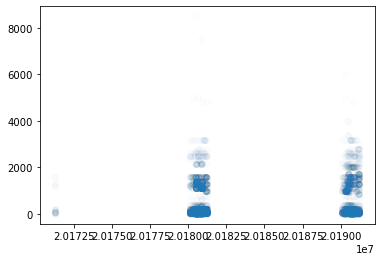

In [231]:
plt.scatter(df['Date'], df['Product Revenue'], alpha =.01);

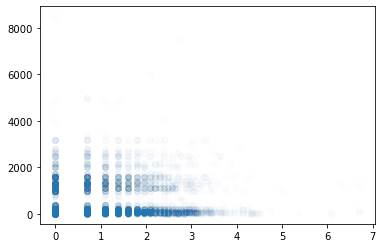

In [232]:
import numpy as np
plt.scatter(np.log(df['Count of Sessions']), df['Product Revenue'], alpha =.01);

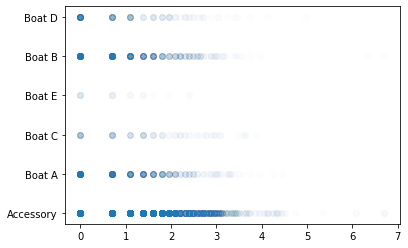

In [233]:
plt.scatter(np.log(df['Count of Sessions']), df['Product'], alpha =.01);

# Building a model

In [234]:
df.dtypes

Transaction ID        object
Date                   int64
Product               object
Source                object
Count of Sessions      int64
Quantity               int64
Product Revenue      float64
Landing Page          object
Device Category       object
dtype: object

In [235]:
from sklearn.model_selection import train_test_split

In [236]:
train, test = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df['Product'], random_state=42)

print(train.shape)
test.shape

(5696, 9)


(1425, 9)

## A simple Random Forest

In [237]:
# Arrange data into X features matrix and y target vector
target = 'Product'
X_train = train.drop(columns=target)
y_train = train[target]

X_test = test.drop(columns=target)
y_test = test[target]

In [242]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on test
pipeline.fit(X_train, y_train)
print('Test Accuracy', pipeline.score(X_test, y_test))

Validation Accuracy 0.9677192982456141


In [ ]:
###NOTES: This doesn't like datetime objects. I commented it out above.

In [ ]:
### Wow, test accuracy of .967! Probably because I have the price in there, ultimate data leakage!

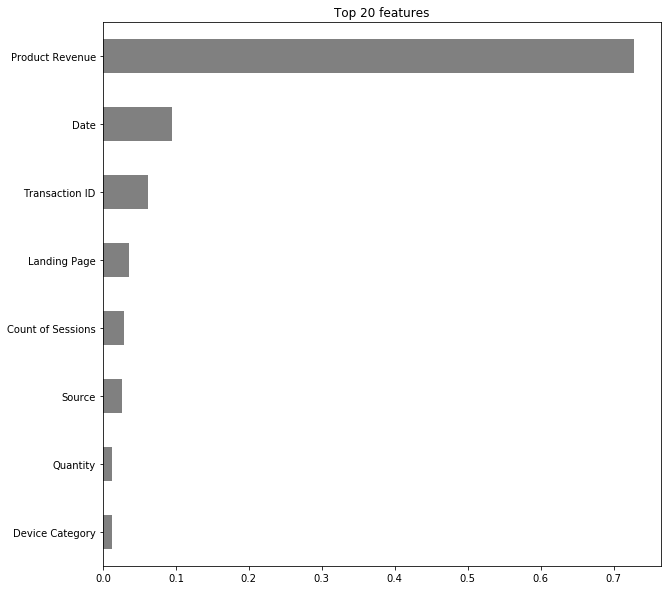

In [244]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');


###HAHAHA yes, turns out the revenue is a great predictor of what kind of product it is!

## Now for an XGBOOST

In [247]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Transaction ID', 'Source',
                                      'Landing Page', 'Device Category'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Transaction ID',
                                          'data_type': dtype('O'),
                                          'mapping': #9984        1
#10328       2
#11228       3
#9648        4
#10719       5
          ... 
#8112     3025
#8373     3026
#8495     3027
#10417    3028
NaN         -2
Length: 3029, dtyp...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                 

In [248]:

from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_test)
print('Validation Accuracy', accuracy_score(y_test, y_pred))

###Sick. I'm so accurate.

Validation Accuracy 0.9866666666666667


# Checking my work

In [239]:
test_frame = df[df['Product']=='Boat A']

test_frame['Product Revenue'].value_counts()

#### There are a few weird outliers, and quite a few where the person bought two boats. I need to find a way to split this into 2 seperate transactions.

1599.00    295
1359.15     97
1399.00     68
3198.00     39
1360.00     31
1190.00     13
1299.00     11
20.00        9
1279.20      9
2798.00      8
2718.30      6
2720.00      4
4797.00      3
1100.00      3
70.00        3
60.00        2
2598.00      2
40.00        2
650.00       1
2558.40      1
265.00       1
80.00        1
2380.00      1
Name: Product Revenue, dtype: int64

In [240]:
test_frame = df[df['Product']=='Accessory']

test_frame['Product Revenue'].value_counts(ascending=False) > 1000

99.00      True
199.00    False
25.00     False
70.00     False
30.00     False
          ...  
14.84     False
43.60     False
280.00    False
55.80     False
11.90     False
Name: Product Revenue, Length: 121, dtype: bool

In [241]:

### TODO
## Double check my wrangling and cleaning functions to make sure that the buckets are accurate (consistent with the new metrics I just imported this evening)

### Could get twice as much data if I could figure out what's up with the 'Product Revenue' metric on Google Analytics

### Add in more features by exporting more csv's from Google Analytics